In [110]:
import numpy as np 
from functools import partial
import matplotlib.pyplot as plt


from sklearn.covariance import empirical_covariance

from regain.covariance.graphical_lasso_ import GraphicalLasso
from regain.datasets.datasets import make_dataset
from regain.scores import log_likelihood, BIC, EBIC, EBIC_m
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from regain.utils import structure_error, error_norm
from sklearn.metrics import matthews_corrcoef

In [6]:
res = make_dataset(n_samples=1000, n_dim_obs=10, n_dim_lat=0, T=1)

0.0%


In [144]:
X = res['data'][0] + np.random.rand(*X.shape)*0.1
theta = res['thetas'][0]

In [26]:
def score(estimator, X_test, score_type='likelihood'):
        # remove mean train 
        # compute empirical covariance of the test set
        test_cov = empirical_covariance(X_test, assume_centered=False)
        
        if score_type.lower() == 'likelihood':
            return log_likelihood(test_cov, estimator.precision_)
        elif score_type.lower() == 'bic':
            return BIC(test_cov, estimator.precision_)
        elif score_type.lower() == 'ebic':
            return EBIC(test_cov, estimator.precision_)
        elif score_type.lower() == 'ebic_m':
            return EBIC_m(test_cov, estimator.precision_)
        else:
            raise ValueError('Undefined type of scores, accepted scores are [likelihood, bic, ebic or ebic_m]')

In [145]:
ss = partial(score, score_type='likelihood')

est = GraphicalLasso()
rscv = RandomizedSearchCV(est, param_distributions={'alpha':np.logspace(-3, 2, 100)}, cv=5, scoring=ss)

sss = ShuffleSplit(n_splits=100, test_size=0.5)
train_scores_likelihood = []
test_scores_likelihood = []
train_likelihood = []
test_likelihood = []
alphas_likelihood = []
test2_likelihood = []
train_scores_likelihood_n = []
test_scores_likelihood_n = []
for train, test in sss.split(X):
    rscv.fit(X[train,:])
    alphas_likelihood.append(rscv.best_estimator_.alpha)
    train_scores_likelihood.append(matthews_corrcoef(theta.ravel()!=0, rscv.best_estimator_.precision_.ravel()!=0))
    train_scores_likelihood_n.append(error_norm(theta, rscv.best_estimator_.precision_))
    train_likelihood.append(ss(rscv.best_estimator_, X[train, :]))
    test_likelihood.append(ss(rscv.best_estimator_, X[test, :]))
    rscv.best_estimator_.fit(X[test,:])
    test_scores_likelihood.append((matthews_corrcoef(theta.ravel()!=0, rscv.best_estimator_.precision_.ravel()!=0)))
    test_scores_likelihood_n.append(error_norm(theta, rscv.best_estimator_.precision_))
    test2_likelihood.append(ss(rscv.best_estimator_, X[test, :]))

/Users/veronica/Desktop/git_repos/scikit-learn/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/veronica/Desktop/git_repos/scikit-learn/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


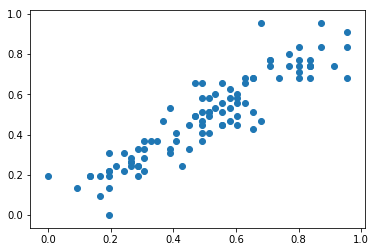

In [146]:
plt.scatter(train_scores_likelihood, test_scores_likelihood)

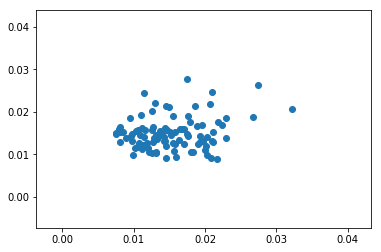

In [147]:
plt.scatter(train_scores_likelihood_n, test_scores_likelihood_n)

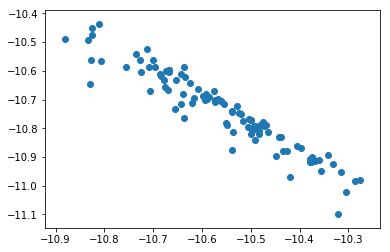

In [148]:
plt.scatter(train_likelihood, test_likelihood)
plt.show()

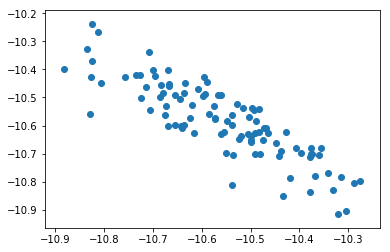

In [149]:
plt.scatter(train_likelihood, test2_likelihood)
plt.show()

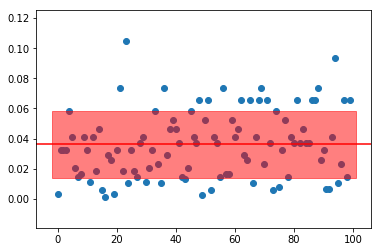

In [151]:
plt.scatter(np.arange(0, len(alphas_likelihood)), alphas_likelihood)
mean = np.mean(alphas_likelihood)
std = np.std(alphas_likelihood)
plt.axhline(mean, c='red')
plt.fill_between(np.arange(-2, len(alphas_likelihood)+2), mean-std, y2=mean+std, color='red', alpha=0.5)

In [152]:
from importlib import reload
import regain.scores; reload(regain.scores)
from regain.scores import EBIC_m

In [167]:
ss = partial(score, score_type='bic')

est = GraphicalLasso()
rscv = RandomizedSearchCV(est, refit=True, param_distributions={'alpha':np.logspace(-3, 2, 100)}, cv=5, scoring=ss)

sss = ShuffleSplit(n_splits=100, test_size=0.5)
train_scores_bic = []
test_scores_bic= []
train_bic = []
test_bic = []
alphas_bic = []
test2_bic = []
train_scores_bic_n = []
test_scores_bic_n = []
for train, test in sss.split(X):
    rscv.fit(X[train,:])
    alphas_bic.append(rscv.best_estimator_.alpha)
    print(alphas_bic[-1])
    
    print(matthews_corrcoef(theta.ravel()!=0, rscv.best_estimator_.precision_.ravel()!=0))
    train_scores_bic.append(matthews_corrcoef(theta.ravel()!=0, rscv.best_estimator_.precision_.ravel()!=0))
    train_scores_bic_n.append(error_norm(theta, rscv.best_estimator_.precision_))
    train_bic.append(ss(rscv.best_estimator_, X[train, :]))
    test_bic.append(ss(rscv.best_estimator_, X[test, :]))
    rscv.best_estimator_.fit(X[test,:])
    print(matthews_corrcoef(theta.ravel()!=0, rscv.best_estimator_.precision_.ravel()!=0))


    test_scores_bic.append((matthews_corrcoef(theta.ravel()!=0, rscv.best_estimator_.precision_.ravel()!=0)))
    test_scores_bic_n.append(error_norm(theta, rscv.best_estimator_.precision_))
    test2_bic.append(ss(rscv.best_estimator_, X[test, :]))

1.3530477745798062
0.5091750772173156
0.5091750772173156
89.02150854450393
0.5091750772173156
0.5091750772173156
10.974987654930567
0.5091750772173156
0.5091750772173156
9.770099572992246
0.5091750772173156
0.5091750772173156
0.1873817422860383
1.0
0.9543135154205278
35.11191734215127
0.5091750772173156
0.5091750772173156
0.9545484566618337
0.5091750772173156
0.5091750772173156
44.30621457583877
0.5091750772173156
0.5091750772173156
2.1544346900318843
0.5091750772173156
0.5091750772173156
3.8535285937105273
0.5091750772173156
0.5091750772173156
3.8535285937105273
0.5091750772173156
0.5091750772173156
22.051307399030456
0.5091750772173156
0.5091750772173156
3.4304692863149193
0.5091750772173156
0.5091750772173156
0.8497534359086438
0.5091750772173156
0.5091750772173156
13.848863713938718
0.5091750772173156
0.5091750772173156
10.974987654930567
0.5091750772173156
0.5091750772173156
2.71858824273294
0.5091750772173156
0.5091750772173156
1.2045035402587825
0.5091750772173156
0.509175077217

In [ ]:
train_scores_bic

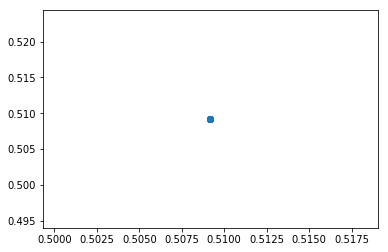

In [159]:
plt.scatter(train_scores_bic, test_scores_bic)

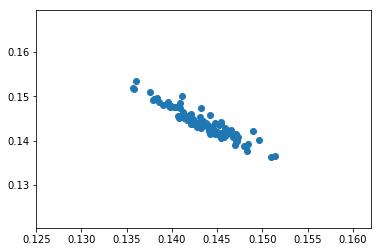

In [160]:
plt.scatter(train_scores_bic_n, test_scores_bic_n)

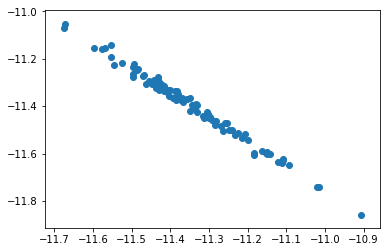

In [161]:
plt.scatter(train_bic, test_bic)
plt.show()

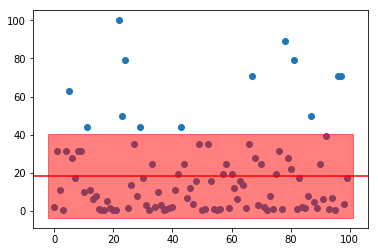

In [162]:
plt.scatter(np.arange(0, len(alphas_bic)), alphas_bic)
mean = np.mean(alphas_bic)
std = np.std(alphas_bic)
plt.axhline(mean, c='red')
plt.fill_between(np.arange(-2, len(alphas_likelihood)+2), mean-std, y2=mean+std, color='red', alpha=0.5)